Set Notebook as being at the main project directory because Notebook cannot load functions when being in subdirectories.

In [1]:
import os
print(os.path.join(os.getcwd(), os.pardir))
os.chdir(os.path.join(os.getcwd(), os.pardir))

/Users/pantelistzamalis/Desktop/python/LAB/dev_tasks/NBs/..


# Load necessary functions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tasks.utils.system_checkers import check_system_compatibility

In [4]:
check_system_compatibility()

>> Python is compatible.
>> scikit-learn is compatible.
>> No GPU is detected. LSTMs and CNNs can be very slow without a GPU. A GPU usage is recommended.
>> TensorFlow is compatible.


In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# plot figures in a pretty way
%matplotlib inline

In [6]:
from tasks.utils.files_saving import save_fig
from tasks.utils.visualization import plot_series, plot_learning_curves

## Load configuration

In [7]:
from tasks.project_configuration.configuration import config_data, save_paths

In [8]:
# config data (dictionary)
config = config_data()

/Users/pantelistzamalis/Desktop/python/LAB/dev_tasks/tasks/project_configuration


In [9]:
config

{'path_app_saving': None,
 'images': 'images',
 'verbose': 0,
 'epochs': 10,
 'batch_size': 32,
 'repeats': 10}

In [10]:
# saving paths
saving_paths = save_paths(config, "Notebooks/nn_rnns_cnns_to_process_sequences")

In [11]:
saving_paths

{'path_images': '/Users/pantelistzamalis/Desktop/python/LAB/dev_tasks/images/Notebooks/nn_rnns_cnns_to_process_sequences'}

# RNNs

To have the same results at any run of the project

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

## Generate the data

In [13]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

### Create the data

In [14]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

### Train / Test split

In [15]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [16]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [17]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## Plot the data

Saving figure time_series_plot


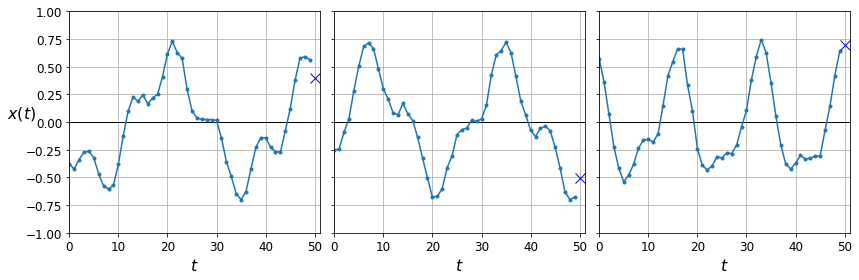

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(n_steps, X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col==0 else None))

save_fig(saving_paths["path_images"], "time_series_plot")
plt.show()

## Computing some basic functions

### Naive predictions using some statistics: Prediction based on `mean`

In [19]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

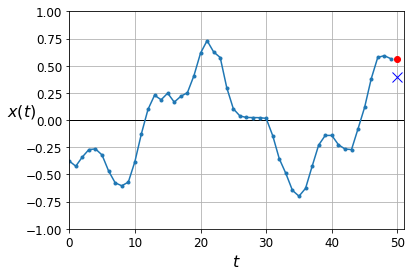

In [20]:
plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Linear predictions with a Simple NN (Perceptron)

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 816us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 869us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 815us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 791us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 904us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 972us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 852us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 873us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 898us/step - loss: 0.0061 

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 634us/step - loss: 0.0042


0.004168087150901556

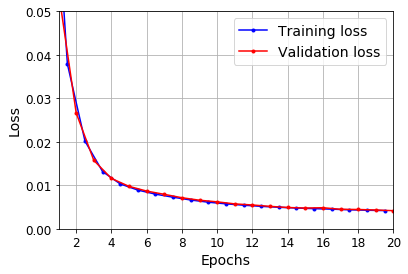

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

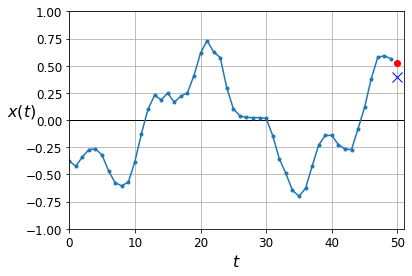

In [24]:
y_pred = model.predict(X_valid)
plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Predictions with a simple RNN

In [25]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0110

In [26]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.01090716291218996

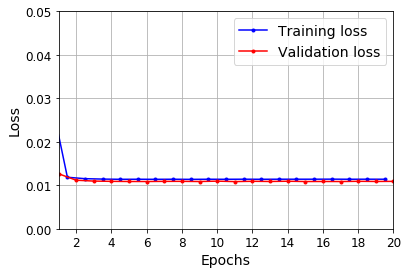

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

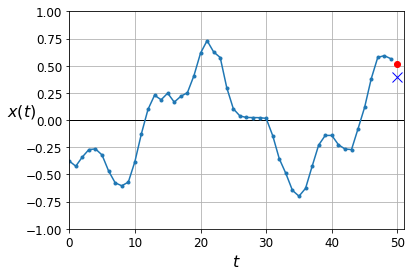

In [28]:
y_pred = model.predict(X_valid)
plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Predictions with Deep RNNs

In [29]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0028 - val_lo

In [30]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.0026385628152638674

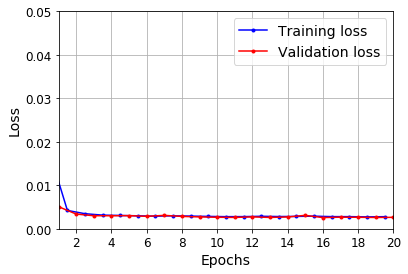

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

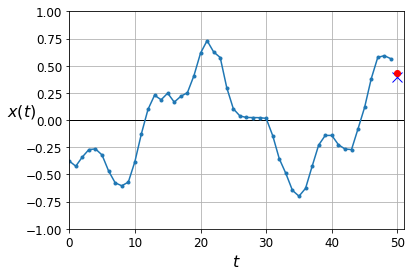

In [32]:
y_pred = model.predict(X_valid)
plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Make the second SimpleRNN layer return only the last output:**

In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0869 - val_loss: 0.0084
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0028 - val_lo

In [34]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0027


0.0026609303895384073

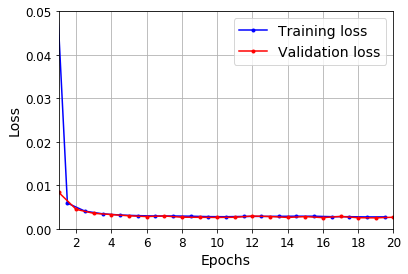

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

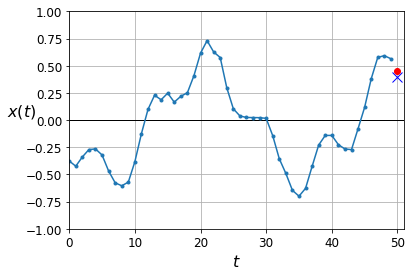

In [36]:
y_pred = model.predict(X_valid)
plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

Change the `seed` to *3* because 42 would give the first series produced above in the train set

In [37]:
np.random.seed(43)

In [38]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [39]:
Y_pred.shape

(1, 10, 1)

In [40]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(n_steps, X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

Saving figure forecast_ahead_plot


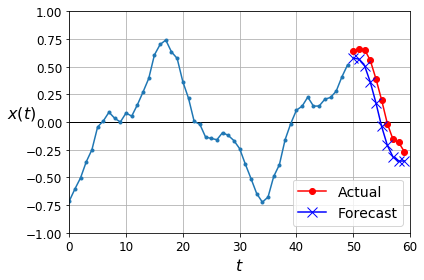

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig(saving_paths["path_images"], "forecast_ahead_plot")
plt.show()

### Use this model to predict the next 10 values, but first I regenerate the sequences with 9 more time steps

In [42]:
np.random.seed(42)  # back to the previous time series
n_steps = 50

In [43]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

### Predict the next 10 values one by one

In [44]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [45]:
Y_pred.shape

(2000, 10)

In [46]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02264998

### Compare this performance with some baselines: naive predictions and a simple linear model

In [47]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1272 - val_loss: 0.0648
Epoch 2/20
219/219 [==============================] - 0s 947us/step - loss: 0.0529 - val_loss: 0.0462
Epoch 3/20
219/219 [==============================] - 0s 853us/step - loss: 0.0410 - val_loss: 0.0380
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0333
Epoch 5/20
219/219 [==============================] - 0s 934us/step - loss: 0.0315 - val_loss: 0.0301
Epoch 6/20
219/219 [==============================] - 0s 932us/step - loss: 0.0288 - val_loss: 0.0279
Epoch 7/20
219/219 [==============================] - 0s 934us/step - loss: 0.0270 - val_loss: 0.0261
Epoch 8/20
219/219 [==============================] - 0s 870us/step - loss: 0.0255 - val_loss: 0.0247
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 10/20
219/219 [==============================] - 0s 981us/step - loss: 0.0234 - va

### Create an RNN that predicts all 10 next values at once:

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0605 - val_loss: 0.0322
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0281 - val_loss: 0.0212
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0147 - val_loss: 0.0131
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0140 - val_loss: 0.0115
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0129 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0103 - val_lo

See the compareness

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

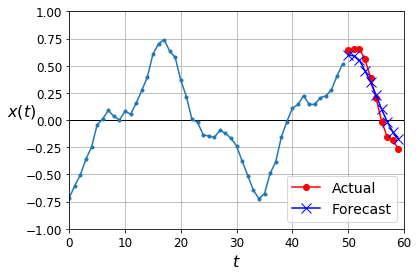

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [52]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [53]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [54]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0528 - last_time_step_mse: 0.0428 - val_loss: 0.0406 - val_last_time_step_mse: 0.0290
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0375 - last_time_step_mse: 0.0244 - val_loss: 0.0371 - val_last_time_step_mse: 0.0263
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0324 - last_time_step_mse: 0.0197 - val_loss: 0.0306 - val_last_time_step_mse: 0.0175
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0303 - last_time_step_mse: 0.0179 - val_loss: 0.0270 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0280 - last_time_step_mse: 0.0155 - val_loss: 0.0276 - val_last_time_step_mse: 0.0178
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0263 - last_time_step_mse: 0.0141 - val_loss: 0.0246 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

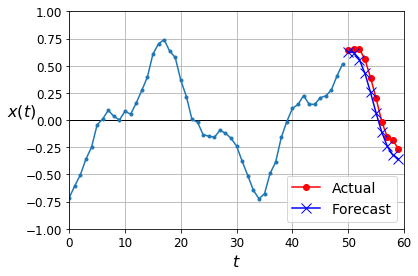

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()